# GSE157832-Aldh2 Adh5
## Xiaonan Wang
## 23May2023

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


# Data in

In [2]:
# Data downloaded from GEO
cr_dir = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Niki/GSE157832/data/'

In [3]:
meta = {'FN': ['GSM4775702_SLX18986_WT_mouse.h5', 'GSM4775703_SLX18986_Aldh2_mouse.h5', 'GSM4775704_SLX18986_Adh5_mouse.h5', 'GSM4775705_SLX18986_Aldh2_Adh5_mouse.h5'],
        'Genotype': ['WT', 'Aldh2-/-', 'Adh5-/-', 'Aldh2-/-\nAdh5-/-'],
        'Condition': ['WT', 'Aldh2KO', 'Adh5KO', 'DKO']       
               }

In [4]:
metaDF = pd.DataFrame.from_dict(meta)
metaDF

FN           Genotype Condition
0          GSM4775702_SLX18986_WT_mouse.h5                 WT        WT
1       GSM4775703_SLX18986_Aldh2_mouse.h5           Aldh2-/-   Aldh2KO
2        GSM4775704_SLX18986_Adh5_mouse.h5            Adh5-/-    Adh5KO
3  GSM4775705_SLX18986_Aldh2_Adh5_mouse.h5  Aldh2-/-\nAdh5-/-       DKO

In [16]:
def ReadInFiles(cr_dir, FN, GT, Con):
    adata = sc.read(cr_dir+FN)
    adata.var_names_make_unique()
    adata.obs['Genotype'] = GT
    adata.obs['Condition'] = Con
    adata.var_names_make_unique()
    return adata

In [17]:
adata = []
for i,row in metaDF.iterrows():
    adata.append(ReadInFiles(cr_dir, row['FN'], row['Genotype'], row['Condition']))

In [18]:
# Combine data sets
adata = anndata.AnnData.concatenate(*adata)

In [19]:
print(adata.shape)

(33328, 20412)


In [20]:
print(adata.obs_keys())

['batch', 'sample', 'doublet_score', 'n_genes', 'percent_mito', 'n_counts', 'cluster', 'Genotype', 'Condition']


In [25]:
# log counts
sc.pp.log1p(adata)

In [26]:
adata.raw = adata

In [28]:
adata.write('./write/raw_afterQC_all_lognorm.h5ad')

# Cell Cycle Assignment

In [29]:
adata = sc.read('./write/raw_afterQC_all_lognorm.h5ad')

In [30]:
# Scaling must be done before scoring
sc.pp.scale(adata)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [31]:
cell_cycle_genes = [x.strip().title() for x in open('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Files/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

97


In [32]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
print('Number of s_genes: '+str(len(s_genes)))
print('Number of g2m_genes: '+str(len(g2m_genes)))
print('Total number of cell cycle genes: '+str(len(cell_cycle_genes)))

Number of s_genes: 43
Number of g2m_genes: 54
Total number of cell cycle genes: 97


In [33]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes, use_raw=False)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    642 total control genes are used. (0:00:04)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    526 total control genes are used. (0:00:08)
-->     'phase', cell cycle phase (adata.obs)


In [34]:
adata.obs['phase'].value_counts().sort_index()

G1     11792
G2M     8751
S      12785
Name: phase, dtype: int64

In [35]:
# save cell cycle assignments
adata.obs[['phase', 'S_score', 'G2M_score']].to_csv('cell_cycle_results.txt')

# Select Highly Variable Genes

In [36]:
adata = sc.read('./write/raw_afterQC_all_lognorm.h5ad')

In [37]:
cell_cycle_results = pd.read_csv('cell_cycle_results.txt', index_col=0)
adata.obs = pd.concat([adata.obs, cell_cycle_results], axis=1)

In [38]:
adata.obs.head(3)

batch  sample  doublet_score  n_genes  percent_mito  \
index                                                                        
AAACCCAAGGATACCG-1-0-0     0  SIGAA2       0.074199     3708      0.007800   
AAACCCAAGGGCAGAG-1-0-0     0  SIGAA2       0.030612     1740      0.007390   
AAACCCAAGTCGAATA-1-0-0     0  SIGAA2       0.068715     2032      0.010806   

                        n_counts cluster Genotype Condition phase   S_score  \
index                                                                         
AAACCCAAGGATACCG-1-0-0   13975.0       1       WT        WT     S  0.323806   
AAACCCAAGGGCAGAG-1-0-0    3789.0       0       WT        WT    G1 -0.668648   
AAACCCAAGTCGAATA-1-0-0    4627.0       0       WT        WT    G1 -0.836899   

                        G2M_score  
index                              
AAACCCAAGGATACCG-1-0-0  -0.211602  
AAACCCAAGGGCAGAG-1-0-0  -0.455521  
AAACCCAAGTCGAATA-1-0-0  -0.580721

In [39]:
# find highly variable genes
# parameters are mainly selected depends on user preference
sc.pp.highly_variable_genes(
    adata, min_mean=0.02, max_mean=3, min_disp=0.3, batch_key='batch', inplace=True)

extracting highly variable genes


/home/xw251/miniconda3/envs/scanpy182/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'phase' as categorical


    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


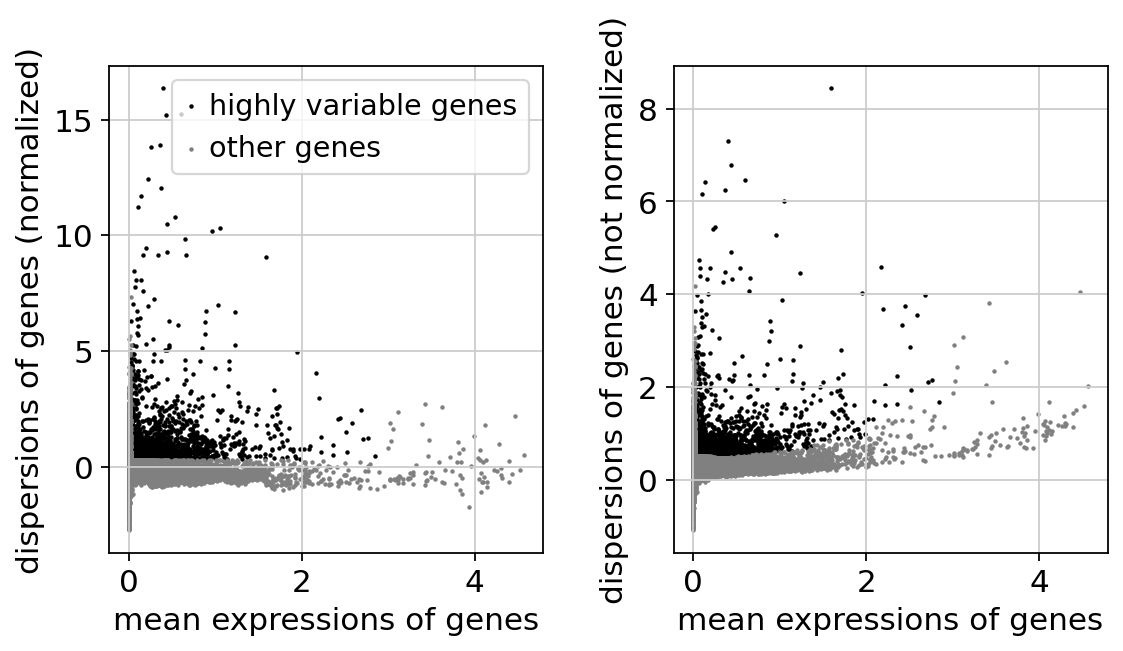

In [40]:
sc.pl.highly_variable_genes(adata)

In [41]:
print(np.sum(adata.var.highly_variable))

2181


In [42]:
adata = adata[:, adata.var.highly_variable].copy()

In [43]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:34)


In [44]:
# scale for pca
sc.pp.scale(adata)
# pca
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:10)


In [45]:
adata.write('./write/raw_afterQC_all_lognorm_processed.h5ad')

In [46]:
adata = sc.read('./write/raw_afterQC_all_lognorm_processed.h5ad')

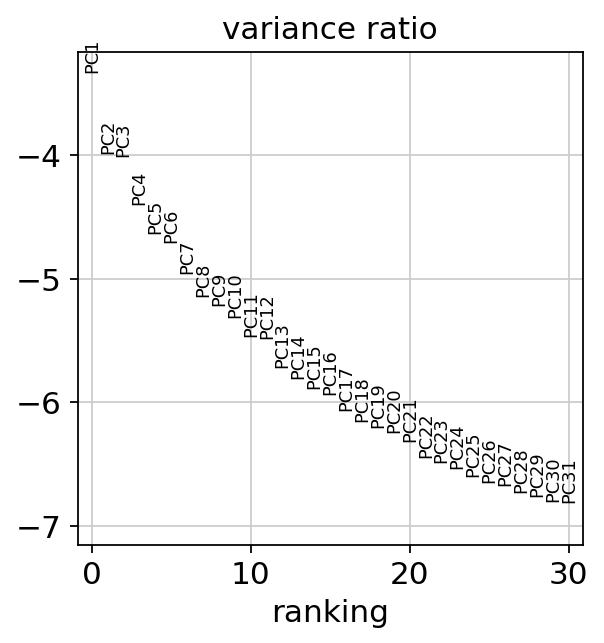

In [47]:
sc.pl.pca_variance_ratio(adata, log=True)

In [48]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)


In [49]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:33)


In [52]:
obs2plot = ['Genotype', 'Condition', 'phase']
print(len(obs2plot))

3


In [66]:
adata.obs['Genotype'] = adata.obs['Genotype'].cat.reorder_categories(adata.obs['Genotype'].cat.categories[[3,1,0,2]])

In [67]:
adata.obs['Condition'] = adata.obs['Condition'].cat.reorder_categories(adata.obs['Condition'].cat.categories[[3,1,0,2]])

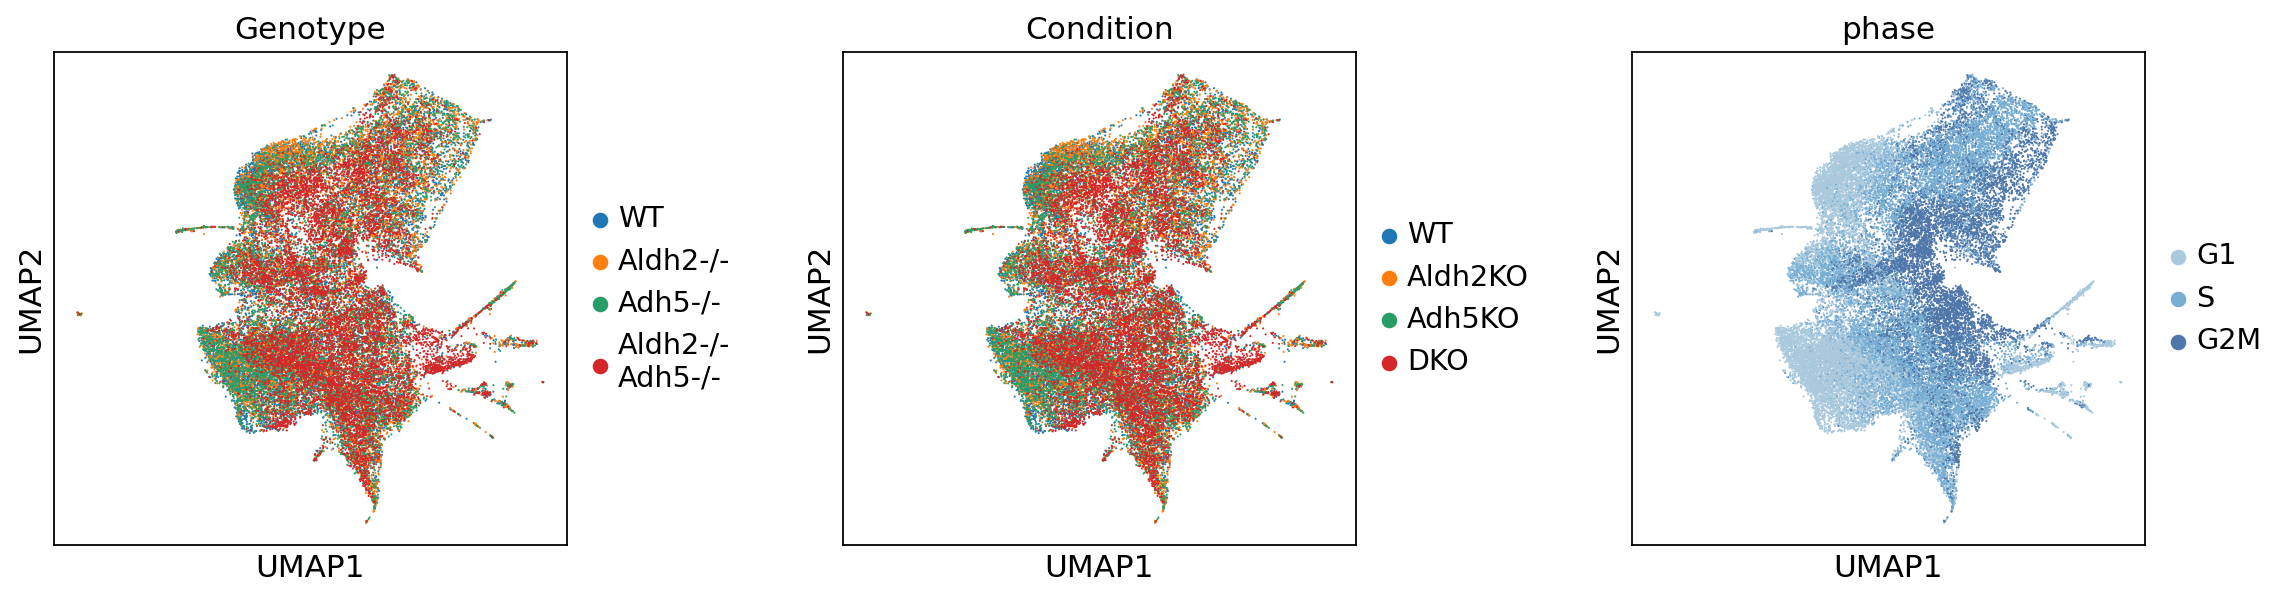

In [68]:
sc.pl.umap(adata, color=obs2plot, color_map=cmap, ncols=4, wspace=0.4)

In [55]:
adata.uns['phase_colors'] = ['#aac9dd', '#78aed3', '#4f77aa']

In [56]:
adata.obs['phase'] = adata.obs['phase'].cat.reorder_categories(['G1', 'S', 'G2M'])

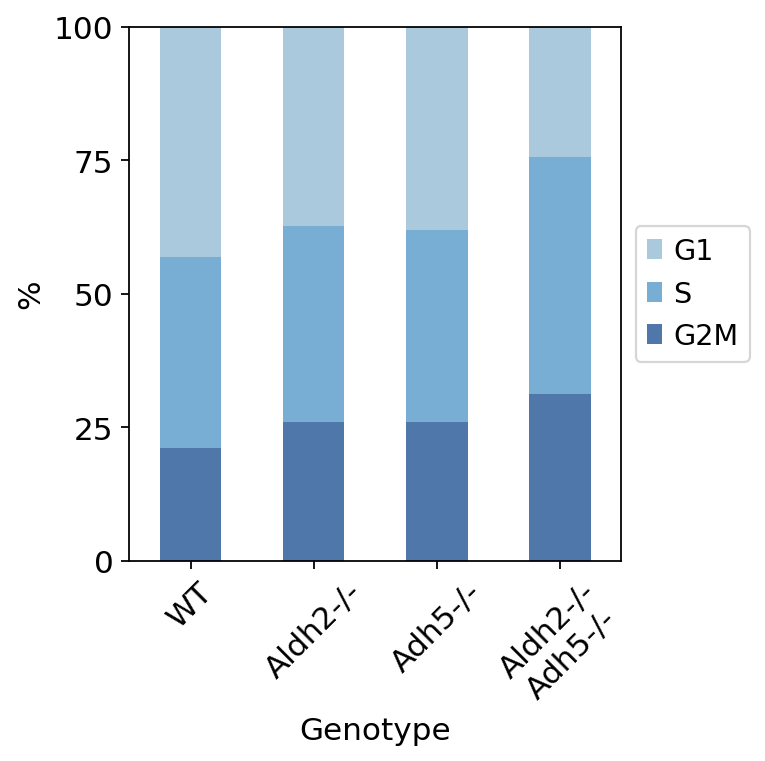

In [71]:
# check cell cycle
tab1 = pd.crosstab(adata.obs['phase'], adata.obs['Genotype'], normalize=1)*100
tab1 = tab1*-1
# Quickly have a look at the proportion
fig, ax = plt.subplots(figsize=(5,5))
tab1.T.plot.bar(stacked=True, ax=ax, color=adata.uns['phase_colors'])
ax.grid(False)
ax.set_ylabel('%')
ax.set_yticks((0,-25,-50,-75,-100))
ax.set_yticklabels(('100','75','50','25','0'))
ax.set_ylim((-100,0))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./figures/barplot_Fig1C_phase.pdf', bbox_inches='tight')

In [72]:
adata.write('./write/raw_afterQC_all_lognorm_processed.h5ad')

# Regress Out Cell Cycle

In [ ]:
adata = sc.read('./write/raw_afterQC_all_lognorm_processed.h5ad')

In [73]:
# regress out cell cycle effect
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

regressing out ['S_score', 'G2M_score']
    finished (0:00:34)


In [74]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:35)


In [75]:
adata.write('./write/raw_afterQC_all_lognorm_processed_regressout_cellcycle.h5ad')

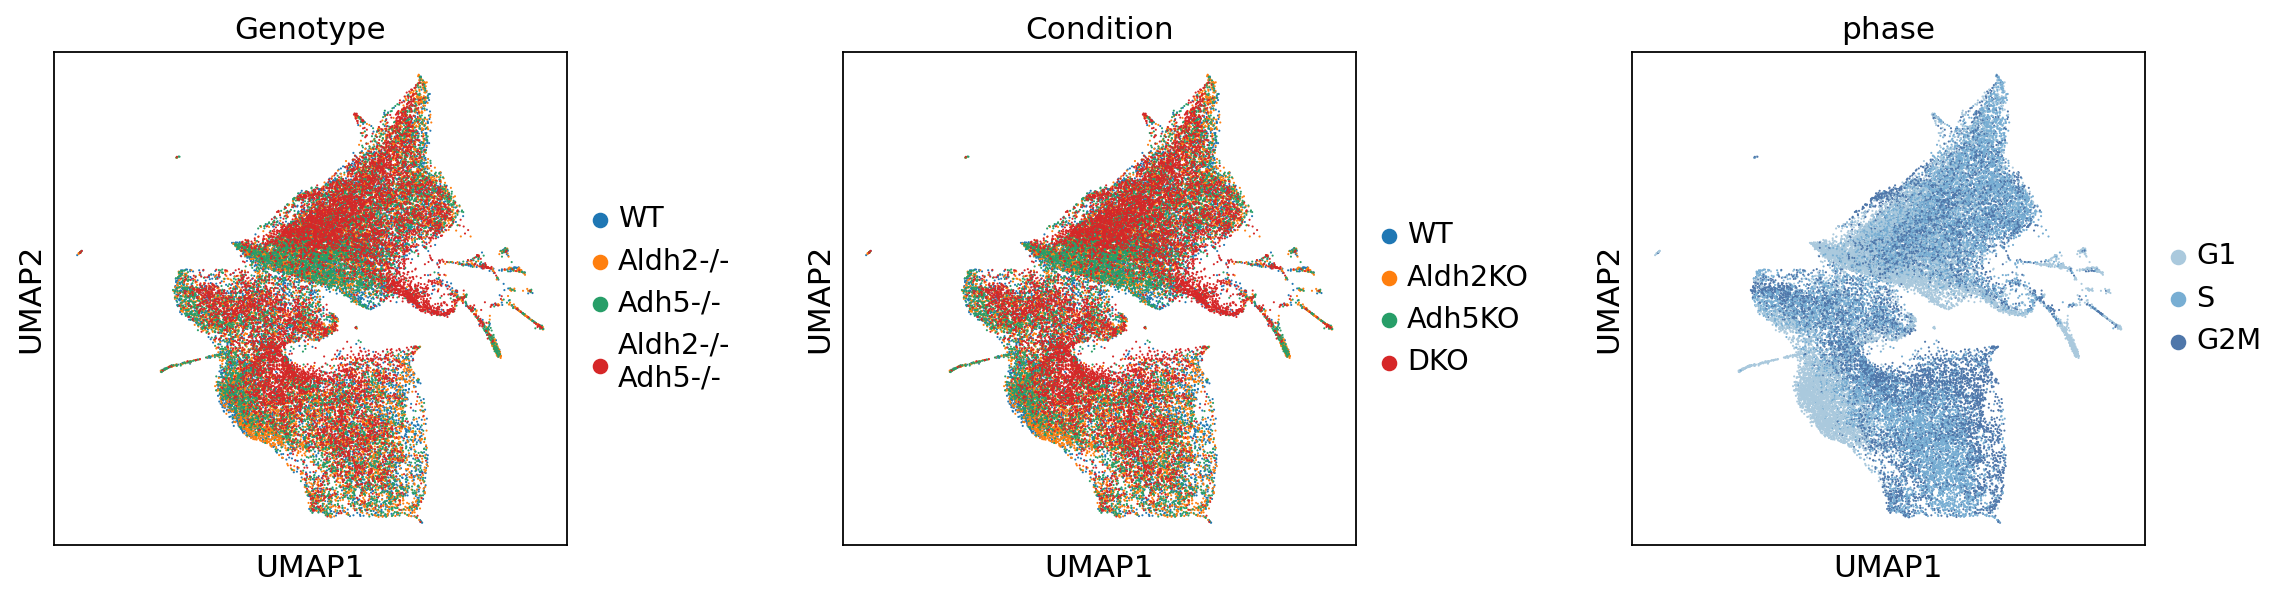

In [76]:
sc.pl.umap(adata, color=obs2plot, color_map=cmap, ncols=4, wspace=0.4)

# Cell Type Analysis

In [77]:
adata = sc.read('./write/raw_afterQC_all_lognorm_processed_regressout_cellcycle.h5ad')

In [78]:
# Import results from 
# 1. Project_onto_Dahlin_Landscape.ipynb
# 2. Project_onto_Nestorowa_Landscape.ipynb
DahlinL = pd.read_csv('Proj_results_dahlin.csv', index_col=0)
NestorowaL = pd.read_csv('Proj_results_nestorowa.csv', index_col=0)

In [79]:
adata.obs['Dahlin_CT'] = DahlinL['Dahlin_CT']
adata.obs['Nestorowa_CT'] = NestorowaL['Nestorowa_CT']

In [80]:
# Replace the HSC and Immature populations in Dahlin Landscape with Nestorowa annotation
anno = np.array(adata.obs['Dahlin_CT'].values).copy()
idx = np.logical_or(adata.obs['Dahlin_CT'] == 'HSC', adata.obs['Dahlin_CT'] == 'Immature')
anno[idx] = adata.obs['Nestorowa_CT'][idx]
toEx = ['MPP1', 'MPP2', 'MPP3']
anno[[x in toEx for x in anno]] = 'MPP'
adata.obs['Combined_CT'] = anno
adata.obs['Combined_CT'] = adata.obs['Combined_CT'].astype('category')

In [81]:
pd.crosstab(adata.obs['Combined_CT'], adata.obs['Condition'])

Condition          WT  Aldh2KO  Adh5KO   DKO
Combined_CT                                 
Basophil          281      277     247   418
Early erythoid   1056      946     940   997
GMP               156      137     132   146
LMPP              851      604     791   491
LTHSC             172      166     184    77
Late erythoid    1102     1318     900   722
Lymphoid          564      467     475   877
MEP               354      349     347   485
MPP              1062      920    1034  1467
Megakaryocyte     267      258     267   246
Middle erythoid   894     1318     857  1265
Neutrophil       1098     1293    1187  1624
STHSC             347      348     348   199

In [82]:
pd.crosstab(adata.obs['Combined_CT'], adata.obs['Condition']).to_csv('CTcount_Condition.csv')

In [83]:
adata.obs['Combined_CT']= adata.obs['Combined_CT'].cat.reorder_categories([
    'LTHSC', 'STHSC', 'MPP', 'LMPP',
       'GMP', 'MEP', 'Megakaryocyte', 'Early erythoid', 'Middle erythoid', 
    'Late erythoid', 'Basophil', 'Lymphoid', 'Neutrophil'])

/home/xw251/miniconda3/envs/scanpy182/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Dahlin_CT' as categorical
/home/xw251/miniconda3/envs/scanpy182/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Nestorowa_CT' as categorical


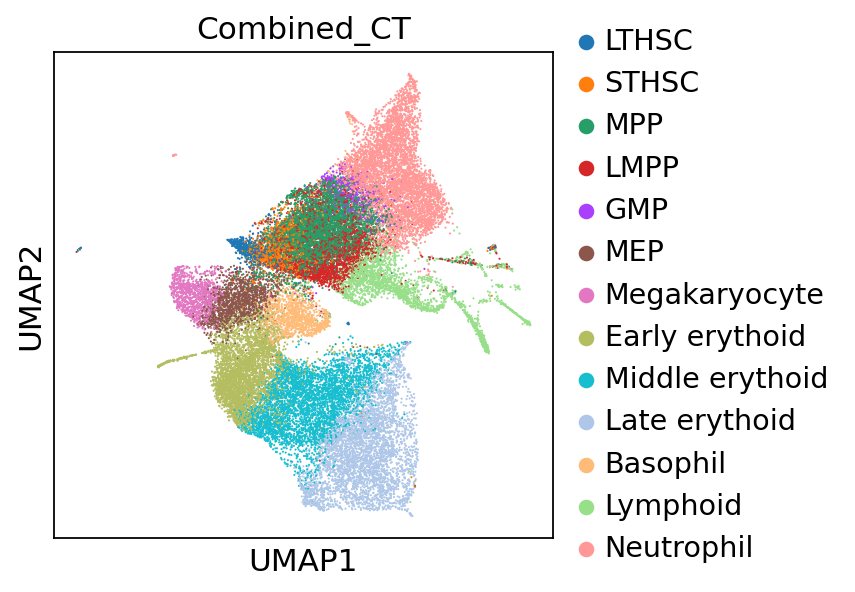

In [84]:
sc.pl.umap(adata, color=['Combined_CT'], save='_combined_CT.pdf')

In [96]:
sc.tl.leiden(adata, key_added='Leiden_v1', resolution=0.8)

running Leiden clustering
    finished: found 24 clusters and added
    'Leiden_v1', the cluster labels (adata.obs, categorical) (0:00:05)


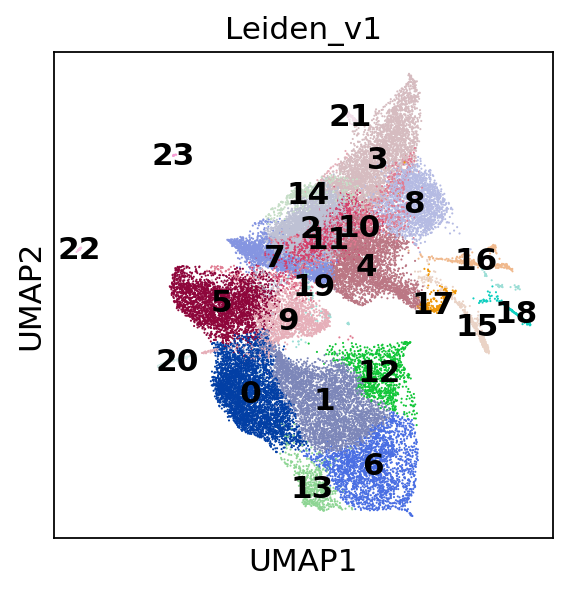

In [99]:
sc.pl.umap(adata, color='Leiden_v1', legend_loc='on data')

Trying to set attribute `._uns` of view, copying.


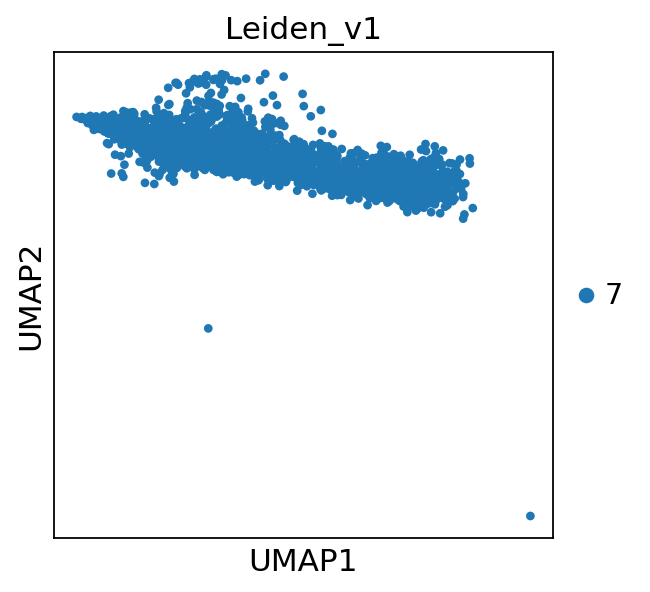

In [100]:
sc.pl.umap(adata[adata.obs['Leiden_v1'] == '7'], color='Leiden_v1')

In [102]:
adata.write('./write/raw_afterQC_all_lognorm_processed_regressout_cellcycle.h5ad')

In [162]:
adata = sc.read('./write/raw_afterQC_all_lognorm_processed_regressout_cellcycle.h5ad')

In [163]:
# remove unknown clusters and calculate percentages
cl = ['15', '16', '18', '22', '23']

In [164]:
adata = adata[~np.in1d(adata.obs['Leiden_v1'], cl)].copy()

In [115]:
tab = pd.crosstab(adata.obs['Combined_CT'], adata.obs['Condition'], normalize=1)

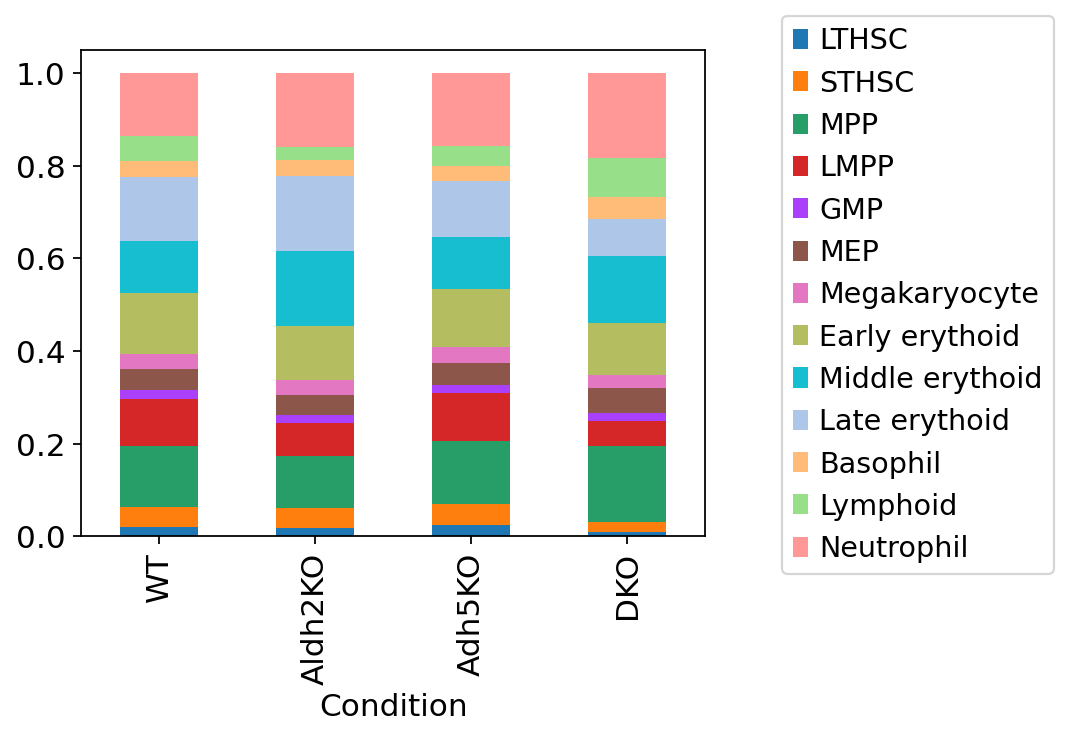

In [125]:
fig, ax = plt.subplots(figsize=(5,4))
tab.T.plot.bar(stacked=True, ax=ax)
ax.grid(False)
plt.legend(bbox_to_anchor =(1.1, 1.1))

In [165]:
adata.write('./write/raw_afterQC_all_lognorm_processed_regressout_cellcycle_rmoutlier.h5ad')

# LT-HSC

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


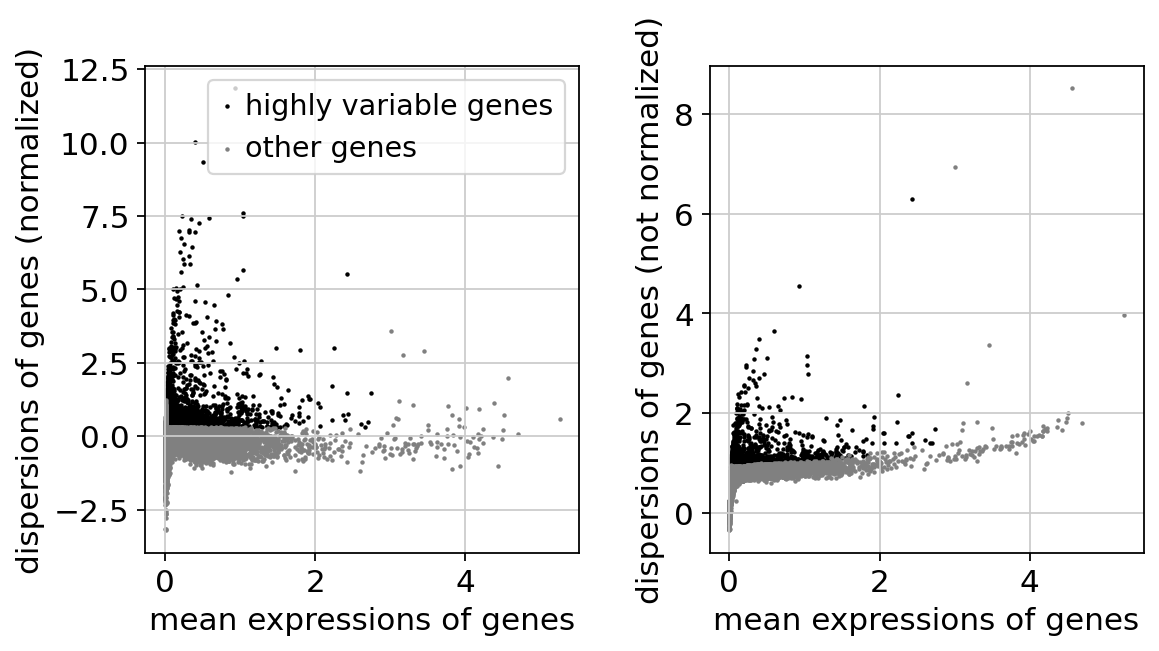

2274
regressing out ['G2M_score', 'S_score', 'n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:05)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


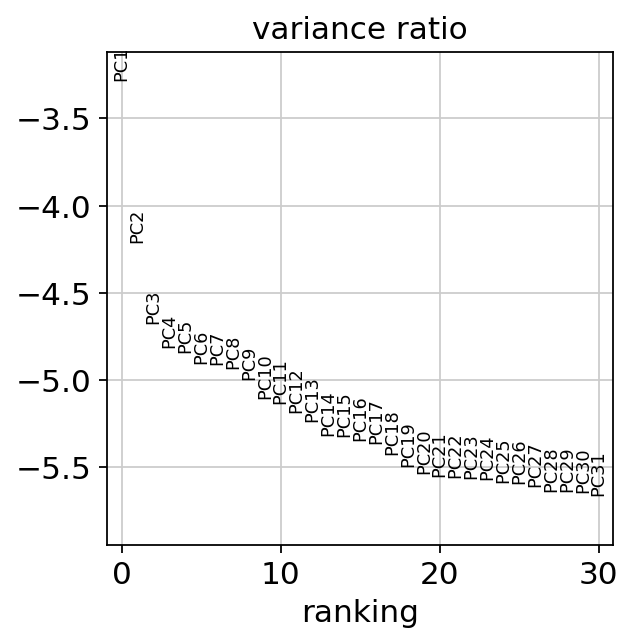

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


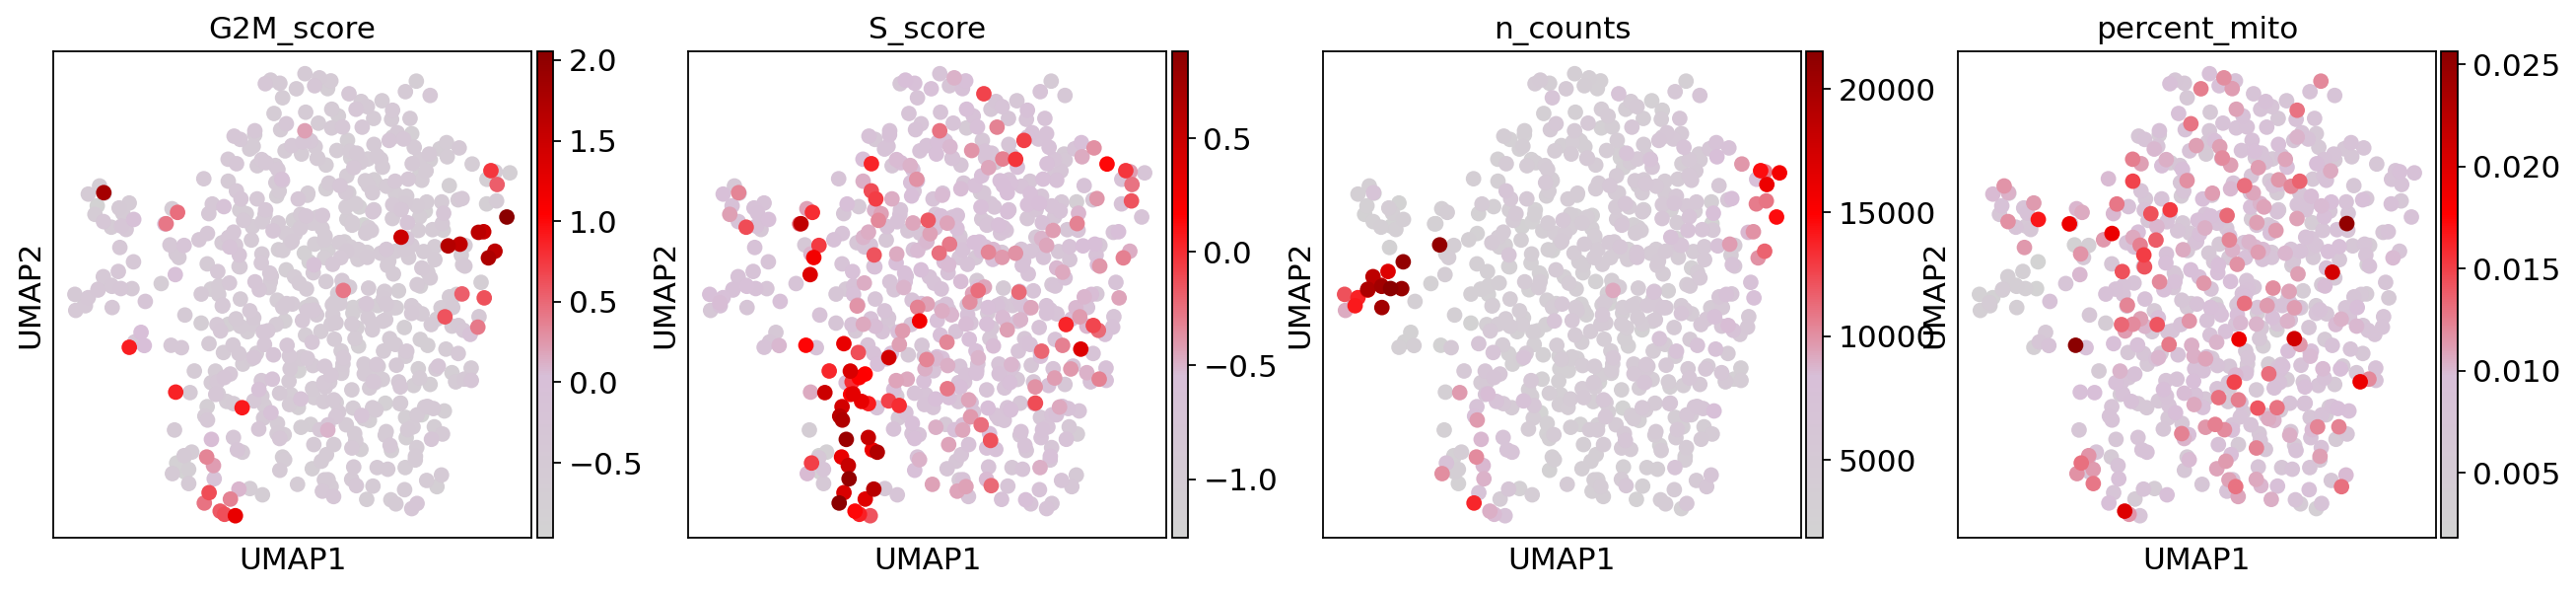

In [103]:
adata_LTHSC = adata[adata.obs['Combined_CT'] == 'LTHSC',:].copy()
adata_LTHSC = anndata.AnnData(X=adata_LTHSC.raw.X, var=adata_LTHSC.raw.var, obs=adata_LTHSC.obs)
adata_LTHSC.raw = adata_LTHSC
sc.pp.highly_variable_genes(
    adata_LTHSC, min_mean=0.02, max_mean=3, min_disp=0.3, batch_key='batch', inplace=True)
sc.pl.highly_variable_genes(adata_LTHSC)
print(np.sum(adata_LTHSC.var.highly_variable))
adata_LTHSC = adata_LTHSC[:, adata_LTHSC.var.highly_variable].copy()
sc.pp.regress_out(adata_LTHSC, keys=['G2M_score', 'S_score', 'n_counts', 'percent_mito'])
sc.pp.scale(adata_LTHSC)
sc.tl.pca(adata_LTHSC, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_LTHSC, log=True)
sc.pp.neighbors(adata_LTHSC)
sc.tl.umap(adata_LTHSC)
sc.pl.umap(adata_LTHSC, color=['G2M_score', 'S_score', 'n_counts', 'percent_mito'], color_map=cmap)

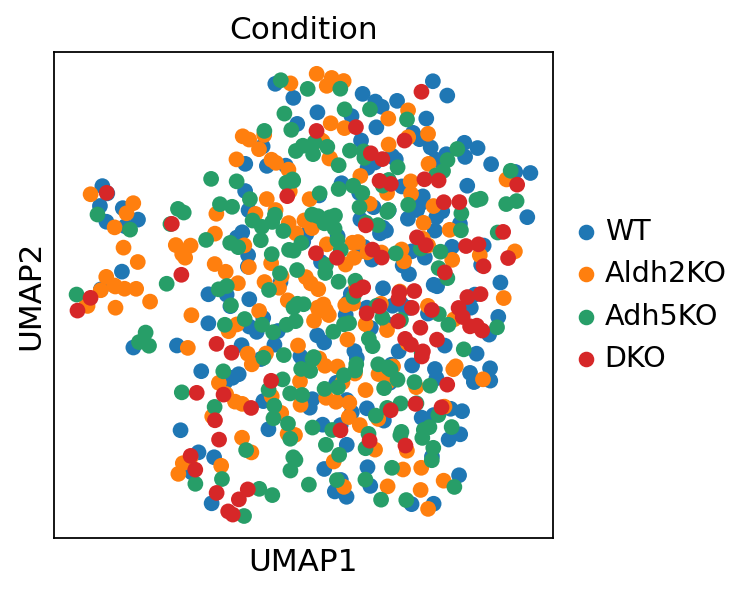

In [104]:
sc.pl.umap(adata_LTHSC, color='Condition')

In [106]:
adata_LTHSC = adata_LTHSC[adata_LTHSC.obs['Leiden_v1'] == '7'].copy()

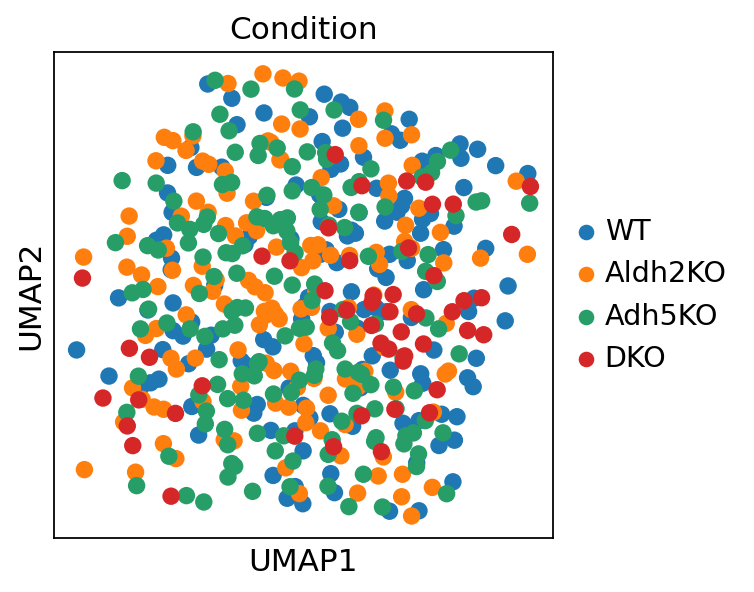

In [107]:
sc.pl.umap(adata_LTHSC, color='Condition')

In [108]:
adata_LTHSC.write('./write/LTHSC.h5ad')

# Plots

In [109]:
adata_LTHSC.obs['Condition'].value_counts()

Adh5KO     159
WT         141
Aldh2KO    138
DKO         51
Name: Condition, dtype: int64

In [131]:
adata.uns['Condition_colors'] = [c[x] for x in adata.obs['Condition'].cat.categories]

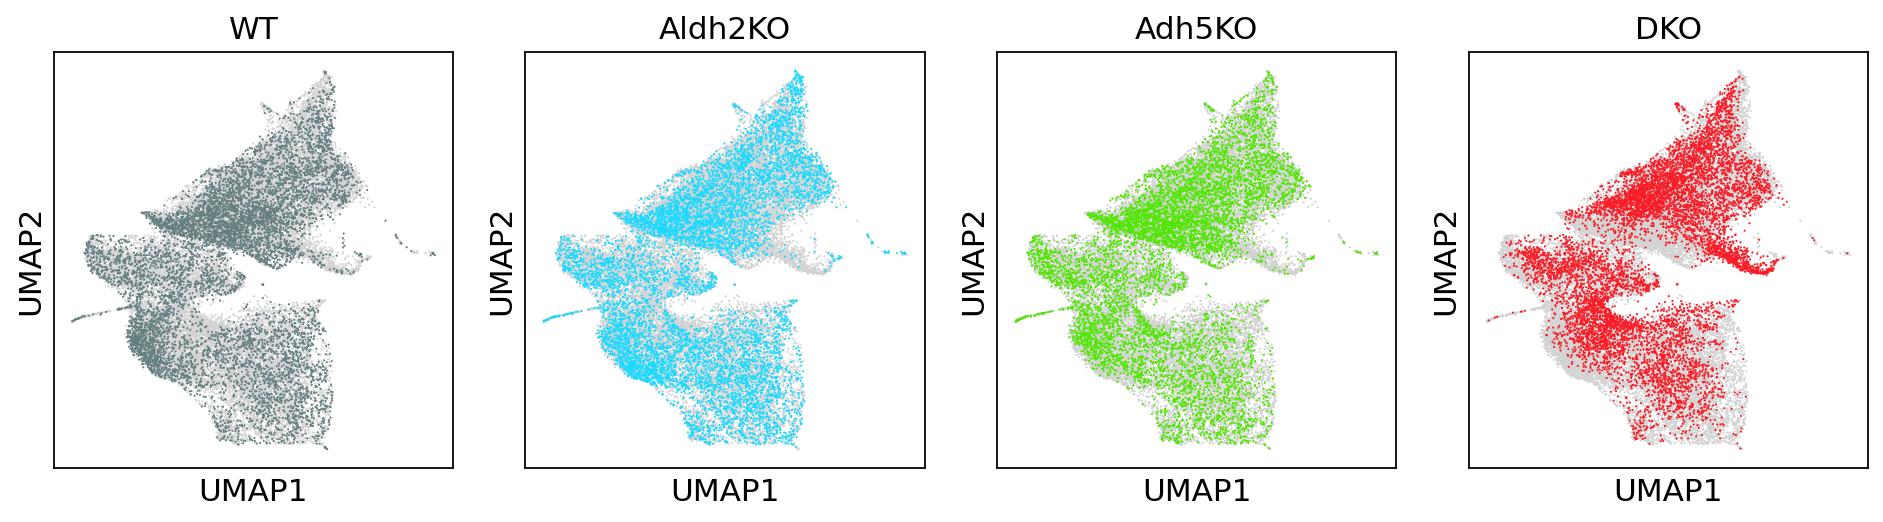

In [132]:
# split in condition
fig, ax=plt.subplots(1,4, figsize=(12,3.5), squeeze=False)
cat = adata.obs['Condition'].cat.categories
ax = ax.flatten()
for i in range(len(cat)):
    sc.pl.umap(adata, color='Condition', groups=cat[i], title=cat[i], ax=ax[i], show=False, legend_loc='')
plt.tight_layout()
plt.savefig('./figures/umap_Fig3a.pdf')

In [134]:
tab1 = pd.crosstab(adata.obs['Combined_CT'], adata.obs['Condition'], normalize=1).T*100

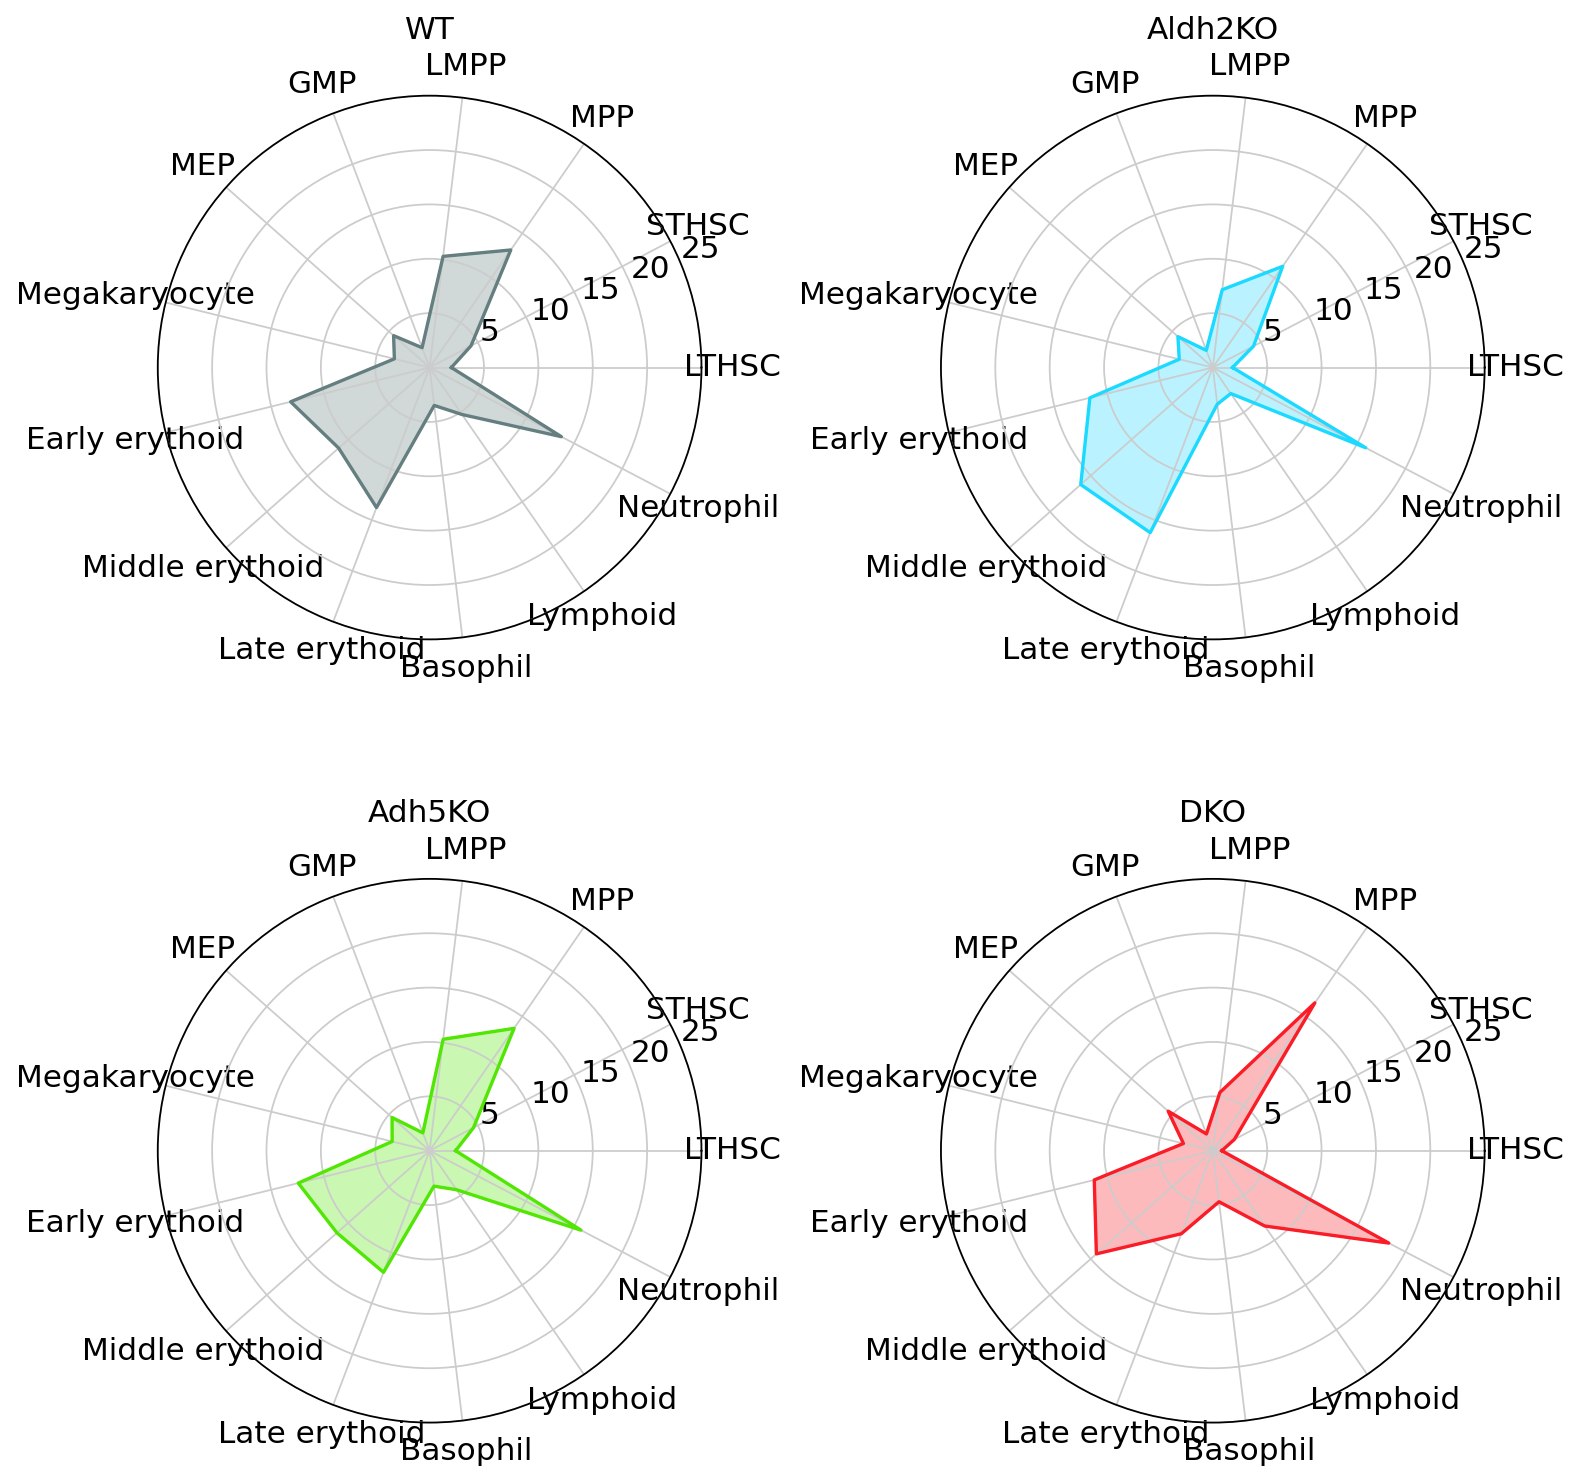

In [135]:
fig, ax = plt.subplots(2,2, figsize=(10, 10), subplot_kw={'projection': 'polar'})
idx = range(4)
nct = len(tab1.columns)
theta = np.linspace(0, 2 * np.pi, nct+1)
ax = ax.flatten()

for i in idx:
    v = tab1.iloc[i,:].values
    ax[i].plot(theta, np.append(v, v[0]), c=c[tab1.index[i]])
    ax[i].fill(theta, np.append(v, v[0]), c=c[tab1.index[i]], alpha=0.3)
    ax[i].set_title(tab1.index[i])
    ax[i].set_ylim([0,25])
    ax[i].set_thetagrids(np.linspace(start=0, stop=360, num=13, endpoint=False), (tab1.columns))

# plt.legend(labels=tab1.index, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('./figures/polar_ct2.pdf',bbox_inches = 'tight')